In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')


---
### 데이터 불러오기 & 컬럼별 확인하기

In [2]:

train=pd.read_csv("./train.csv", encoding='utf-8')
test=pd.read_csv("./test.csv", encoding='utf-8')

train.head(2)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0


In [3]:
train.isnull().sum() , test.isnull().sum() 
#직업유형 > null값 많음

(index               0
 gender              0
 car                 0
 reality             0
 child_num           0
 income_total        0
 income_type         0
 edu_type            0
 family_type         0
 house_type          0
 DAYS_BIRTH          0
 DAYS_EMPLOYED       0
 FLAG_MOBIL          0
 work_phone          0
 phone               0
 email               0
 occyp_type       8171
 family_size         0
 begin_month         0
 credit              0
 dtype: int64,
 index               0
 gender              0
 car                 0
 reality             0
 child_num           0
 income_total        0
 income_type         0
 edu_type            0
 family_type         0
 house_type          0
 DAYS_BIRTH          0
 DAYS_EMPLOYED       0
 FLAG_MOBIL          0
 work_phone          0
 phone               0
 email               0
 occyp_type       3152
 family_size         0
 begin_month         0
 dtype: int64)

---   
### 데이터 전처리 : 컬럼별 확인하기   

    - 자녀수, 연소득, 가족규모 > 연속형   
    - 성별, 자차유무,부동산유무,(핸드폰유무, 업무용폰유무,전화유무,이메일유무) > 명목형 이진분류    => 유무 1 / 0 으로 바꾸기(앞 3개만)      
    - 소득타입, 교육수준, 결혼여부, 생활방식 > 명목형 5 / 4/ 5/ 6                             => 라벨인코더    
    - 출생일, 업무시작일, 신용카드발급월 > -연속형                                            => 나이/연차/사용월 수정하기   
    - 직업유형 > 명목형  n                                                                  => 컬럼 뺄까...?   

In [4]:
# 1.성별, 자차유무,부동산유무

train.gender=train.gender.apply(lambda x: 0 if x=='M' else 1)    # 남성 0  , 여성 1
train[['car','reality']]=train[['car','reality']].applymap(lambda x : 0 if x=='N' else 1)  #자차,부동산 무 0 , 유 1
train.head(2)


test.gender=test.gender.apply(lambda x: 0 if x=='M' else 1)    # 남성 0  , 여성 1
test[['car','reality']]=test[['car','reality']].applymap(lambda x : 0 if x=='N' else 1)  #자차,부동산 무 0 , 유 1
test.head(2)


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,0,1,0,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,1,0,1,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0


In [5]:
# 2. 소득타입, 교육수준, 결혼여부, 생활방식  	income_type	  edu_type	 family_type	 house_type  >>라벨인코더 사용
 
cols=['income_type','edu_type','family_type','house_type']
le = LabelEncoder()

for col in cols:
    le.fit(train[col])
    le_encoded=le.transform(train[col])
    train[col]=le_encoded

for col in cols:
    le.fit(test[col])
    le_encoded=le.transform(test[col])
    test[col]=le_encoded


train.head(2)


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,1,0,0,0,202500.0,0,1,1,2,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,1,0,1,1,247500.0,0,4,0,1,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0


In [6]:
# 3. 출생일,                             -  //365 > divmod(일수,365) > 나이+남은일수 > 남은일수는다시 /365
#                                       divmod(-생일,365) => (나이, 나머지)      => 나이 + 나머지/365
#                                       birth=divmod(-train.DAYS_BIRTH)     => birth[1]+birth[2]/365
# 업무시작일 양수: 무직일수 / 음수 : 일한 날짜
#   무직/고용 분리해서 컬럼 추가하기
#   고용 (-) : 출생일과 동일하게 
#   무직 (+) : 무직 일수도 계산하기

# 신용카드발급월  >  card=divmod(-날짜,12) => (년,나머지)        => card[1]+card[2]/12


In [7]:
# 3-1 출생일
birth=divmod(-train.DAYS_BIRTH,365)
train.DAYS_BIRTH=birth[0]+birth[1]/365

birth_test=divmod(-test.DAYS_BIRTH,365)
test.DAYS_BIRTH=birth_test[0]+birth_test[1]/365

train.head()


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,1,0,0,0,202500.0,0,1,1,2,38.079452,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,1,0,1,1,247500.0,0,4,0,1,31.178082,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,0,1,1,0,450000.0,4,1,1,1,52.293151,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,1,0,1,0,202500.0,0,4,1,1,41.336986,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,1,1,1,0,157500.0,2,1,1,1,41.197260,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [8]:
# 3-2 업무시작일 > 무직 - / 고용+ ? 컬럼을 분리?
# 컬럼 분리하지 않고 일수로 사용 (근로 + / 무직 -)
employed=divmod(-train.DAYS_EMPLOYED,365)
train.DAYS_EMPLOYED=employed[0]+employed[1]/365

employed=divmod(-test.DAYS_EMPLOYED,365)
test.DAYS_EMPLOYED=employed[0]+employed[1]/365

train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,1,0,0,0,202500.0,0,1,1,2,38.079452,12.901370,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,1,0,1,1,247500.0,0,4,0,1,31.178082,4.219178,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,0,1,1,0,450000.0,4,1,1,1,52.293151,12.147945,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,1,0,1,0,202500.0,0,4,1,1,41.336986,5.731507,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,1,1,1,0,157500.0,2,1,1,1,41.197260,5.767123,1,0,0,0,Managers,2.0,-26.0,2.0


In [9]:
test.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,0,1,0,0,112500.0,1,4,0,1,60.246575,-1000.665753,1,0,1,0,NaN,2.0,-60.0
1,26458,1,0,1,0,135000.0,2,1,1,1,51.956164,23.756164,1,0,1,0,Core staff,2.0,-36.0
2,26459,1,0,1,0,69372.0,4,4,1,1,43.526027,0.594521,1,1,1,0,Laborers,2.0,-40.0
3,26460,0,1,0,0,112500.0,0,4,1,1,52.794521,6.934247,1,1,0,0,Drivers,2.0,-41.0
4,26461,1,1,1,0,225000.0,2,1,1,1,48.827397,25.712329,1,1,0,0,Managers,2.0,-8.0


In [10]:
# 3-3 신용카드발급월  >  card=divmod(-날짜,12) => (년,나머지)        => card[1]+card[2]/12
card=divmod(-train.begin_month,12)
train.begin_month=card[0]+card[1]/12

card=divmod(-test.begin_month,12)
test.begin_month=card[0]+card[1]/12

train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,1,0,0,0,202500.0,0,1,1,2,38.079452,12.901370,1,0,0,0,NaN,2.0,0.500000,1.0
1,1,1,0,1,1,247500.0,0,4,0,1,31.178082,4.219178,1,0,0,1,Laborers,3.0,0.416667,1.0
2,2,0,1,1,0,450000.0,4,1,1,1,52.293151,12.147945,1,0,1,0,Managers,2.0,1.833333,2.0
3,3,1,0,1,0,202500.0,0,4,1,1,41.336986,5.731507,1,0,1,0,Sales staff,2.0,3.083333,0.0
4,4,1,1,1,0,157500.0,2,1,1,1,41.197260,5.767123,1,0,0,0,Managers,2.0,2.166667,2.0


In [11]:
# 4. 직업 유형
train.occyp_type.unique()

array([nan, 'Laborers', 'Managers', 'Sales staff',
       'High skill tech staff', 'Core staff', 'Drivers', 'Medicine staff',
       'Accountants', 'Realty agents', 'Security staff', 'Cleaning staff',
       'Private service staff', 'Cooking staff', 'Secretaries',
       'HR staff', 'IT staff', 'Low-skill Laborers',
       'Waiters/barmen staff'], dtype=object)

In [12]:
test.occyp_type.nunique()

18

In [13]:
len(train.occyp_type), train.occyp_type.isnull().sum()

# 약 31% null값 >> 컬럼 삭제

(26457, 8171)

In [14]:
del train['occyp_type']
del test['occyp_type']

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  int64  
 2   car            26457 non-null  int64  
 3   reality        26457 non-null  int64  
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  int32  
 7   edu_type       26457 non-null  int32  
 8   family_type    26457 non-null  int32  
 9   house_type     26457 non-null  int32  
 10  DAYS_BIRTH     26457 non-null  float64
 11  DAYS_EMPLOYED  26457 non-null  float64
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

<AxesSubplot: >

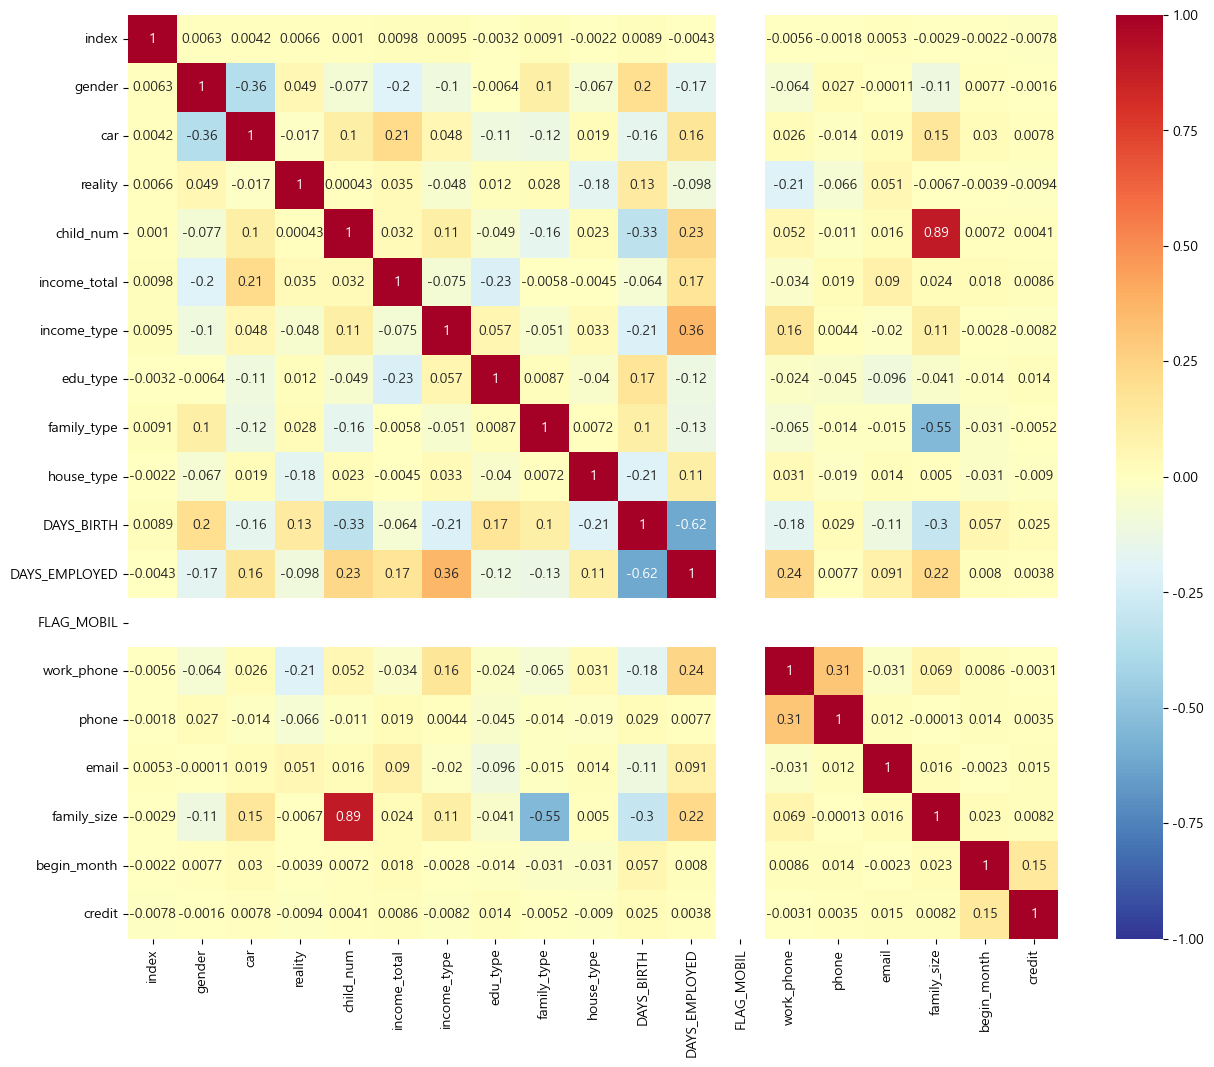

In [16]:
#컬럼별 상관관계 확인
train_cor=train.corr()
plt.figure(figsize=(15,12))
sns.heatmap(train_cor, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1
              )

In [17]:
# child_num / family_size : 상관관계 너무 높음 >> 하나 삭제하기
# family_size / family_type >> 유사한 내용을 담고있을듯 ? 하나 삭제하기
 #            > family_size 삭제하기
# days_birth / days_employed >> 은퇴나이 등 유사할듯 > 하나 삭제하기
#               >days_birth 삭제하기


In [18]:
train.drop(columns=['family_size','DAYS_BIRTH'],axis=1,inplace=True)
test.drop(columns=['family_size','DAYS_BIRTH'],axis=1,inplace=True)


In [19]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,begin_month,credit
0,0,1,0,0,0,202500.0,0,1,1,2,12.901370,1,0,0,0,0.500000,1.0
1,1,1,0,1,1,247500.0,0,4,0,1,4.219178,1,0,0,1,0.416667,1.0
2,2,0,1,1,0,450000.0,4,1,1,1,12.147945,1,0,1,0,1.833333,2.0
3,3,1,0,1,0,202500.0,0,4,1,1,5.731507,1,0,1,0,3.083333,0.0
4,4,1,1,1,0,157500.0,2,1,1,1,5.767123,1,0,0,0,2.166667,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,1,0,0,2,225000.0,2,4,1,1,5.435616,1,0,0,0,0.166667,1.0
26453,26453,1,0,1,1,180000.0,4,1,2,1,6.780822,1,0,0,0,3.916667,2.0
26454,26454,1,1,0,0,292500.0,4,4,0,5,5.520548,1,0,0,0,2.083333,2.0
26455,26455,0,0,1,0,171000.0,4,2,3,1,0.293151,1,0,0,0,4.916667,2.0


In [20]:
train.to_csv('./train3.csv',encoding='utf-8')
test.to_csv('./test3.csv',encoding='utf-8')

---   
### 분류모델 학습하기

In [21]:
# 1. 랜덤포레스트
y = train["credit"]
X = train.drop("credit", axis=1)
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.2, random_state=156)


rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [22]:
y_pred = rfc.predict_proba(X_test)
y_pred

array([[0.21, 0.77, 0.02],
       [0.12, 0.18, 0.7 ],
       [0.11, 0.14, 0.75],
       ...,
       [0.11, 0.28, 0.61],
       [0.3 , 0.13, 0.57],
       [0.05, 0.11, 0.84]])

In [23]:
log_loss(y_test, y_pred)

#값이 낮아야 예측이 잘된것, 컬럼을 몇개 줄인 후 다시 해보자

0.7720399104681418

In [24]:
# 2. 8개 특성만 사용한 랜덤포레스트

X2=X[['car','reality','income_total','income_type','house_type','DAYS_EMPLOYED','work_phone','begin_month']]
y2 = train["credit"]
X_train, X_test, y_train, y_test =train_test_split(X2, y2, test_size=0.3, random_state=156)


rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred2 = rfc.predict_proba(X_test)
y_pred2

log_loss(y_test, y_pred2)


# 다시 높아짐.. 원래 컬럼에서 정규화 후 진행해보자

1.1534457377420273

In [25]:
# 3. 정규화를 사용, 다른 모델 찾아보기 
scaler = StandardScaler()
train_ss = scaler.fit_transform(train)
train_df=pd.DataFrame(train_ss,columns=train.columns)

In [26]:
train_df.drop(columns='index',axis=1, inplace=True)
train_df.credit=train.credit

train_df.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,begin_month,credit
0,0.703562,-0.782463,-1.437626,-0.573599,0.149136,-1.379572,-1.563528,-0.385583,0.762704,0.463930,0.0,-0.538417,-0.645705,-0.316937,-1.215231,1.0
1,0.703562,-0.782463,0.695591,0.764529,0.590848,-1.379572,0.672647,-1.435432,-0.296331,0.440878,0.0,-0.538417,-0.645705,3.155199,-1.275620,1.0
2,-1.421339,1.278015,0.695591,-0.573599,2.578550,0.924752,-1.563528,-0.385583,-0.296331,0.461929,0.0,-0.538417,1.548696,-0.316937,-0.249003,2.0
3,0.703562,-0.782463,0.695591,-0.573599,0.149136,-1.379572,0.672647,-0.385583,-0.296331,0.444893,0.0,-0.538417,1.548696,-0.316937,0.656836,0.0
4,0.703562,1.278015,0.695591,-0.573599,-0.292575,-0.227410,-1.563528,-0.385583,-0.296331,0.444988,0.0,-0.538417,-0.645705,-0.316937,-0.007446,2.0


In [27]:
#정규화 한 값으로 다른 모델 찾아보기 > pycaret 사용
from pycaret.classification import *
py_try=setup(data=train_df,target='credit',session_id=123)

ModuleNotFoundError: No module named 'pycaret'

In [ ]:
best_model = compare_models()

#모델별 큰 차이는 없는편,  최적 모델이라고 나오는 lgbm 사용해보기

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6977,0.6947,0.4212,0.6842,0.6192,0.2304,0.3153,0.0860
rf,Random Forest Classifier,0.6946,0.7290,0.5101,0.6655,0.6709,0.3412,0.3517,0.2730
gbc,Gradient Boosting Classifier,0.6924,0.6474,0.4090,0.6635,0.6073,0.2072,0.2979,0.7090
ada,Ada Boost Classifier,0.6919,0.6227,0.4035,0.6229,0.6019,0.1965,0.2995,0.0920
et,Extra Trees Classifier,0.6663,0.6946,0.4949,0.6399,0.6480,0.2970,0.3023,0.2850
nb,Naive Bayes,0.6450,0.5974,0.3540,0.5265,0.5394,0.0583,0.0996,0.0200
lda,Linear Discriminant Analysis,0.6439,0.6085,0.3342,0.5145,0.5052,0.0028,0.0252,0.0270
lr,Logistic Regression,0.6438,0.6085,0.3342,0.5145,0.5052,0.0027,0.0249,0.6360
svm,SVM - Linear Kernel,0.6433,0.0000,0.3333,0.4138,0.5036,0.0000,0.0000,0.0650
ridge,Ridge Classifier,0.6433,0.0000,0.3333,0.4138,0.5036,0.0000,0.0000,0.0180


In [ ]:
tuned_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7009,0.6926,0.4455,0.6824,0.6378,0.2622,0.3253
1,0.6992,0.6867,0.4415,0.6689,0.6357,0.2607,0.3201
2,0.7041,0.7012,0.4485,0.6911,0.6413,0.2700,0.3357
3,0.6949,0.6896,0.4319,0.6680,0.6264,0.2407,0.3067
4,0.6998,0.6925,0.4477,0.6867,0.6384,0.2630,0.3227
5,0.6971,0.6887,0.4386,0.6545,0.6335,0.2596,0.3150
6,0.6890,0.7024,0.4301,0.6433,0.6238,0.2391,0.2907
7,0.7019,0.6953,0.4472,0.6830,0.6395,0.2674,0.3294
8,0.6928,0.7085,0.4393,0.6570,0.6314,0.2505,0.3031


In [ ]:
predictions = predict_model(tuned_model, data=test)

In [ ]:
#light gbm 
X_train, X_test, y_train, y_test =train_test_split(train_df.iloc[:,:-1], train.credit, test_size=0.3, random_state=156)

lgb_clf = lgb.LGBMClassifier()
lgb_clf.fit(X_train, y_train)

# Get class probabilities for the test set
probas = lgb_clf.predict_proba(X_test)

log_loss(y_test,probas)
#rf보다 더 안좋은듯? 우선 한번 시도해보기

0.7723802448540172

In [ ]:
#test 데이터 정규화 후 lgbm 적용해보기
#정규화
scaler = StandardScaler()
test_ss = scaler.fit_transform(test)
test_df=pd.DataFrame(test_ss,columns=test.columns)
test_df.drop(columns='index',axis=1, inplace=True)

test_df.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,begin_month
0,-1.435588,1.278418,-1.417189,-0.596243,-0.714468,-0.813916,0.674315,-1.426741,-0.29971,-2.211692,0.0,-0.542831,1.541090,-0.305963,2.063135
1,0.696579,-0.782217,0.705622,-0.596243,-0.492869,-0.235563,-1.563703,-0.384944,-0.29971,0.495587,0.0,-0.542831,1.541090,-0.305963,0.595043
2,0.696579,-0.782217,0.705622,-0.596243,-1.139229,0.921143,0.674315,-0.384944,-0.29971,0.434377,0.0,1.842192,1.541090,-0.305963,0.839725
3,-1.435588,1.278418,-1.417189,-0.596243,-0.714468,-1.392269,0.674315,-0.384944,-0.29971,0.451131,0.0,1.842192,-0.648891,-0.305963,0.900895
4,0.696579,1.278418,0.705622,-0.596243,0.393527,-0.235563,-1.563703,-0.384944,-0.29971,0.500757,0.0,1.842192,-0.648891,-0.305963,-1.117732


In [ ]:
#lgbm
lgb_clf = lgb.LGBMClassifier()
train_X=train_df.iloc[:,:-1]
train_y=train.credit
lgb_clf.fit(train_X,train_y)

# Get class probabilities for the test set
probas = lgb_clf.predict_proba(test_df)

---   
### 미션 파일 만들기

In [ ]:
probas
result=pd.DataFrame(probas,columns=[[0,1,2]])

In [ ]:
result

,0,1,2
0,0.098497,0.211696,0.689806
1,0.113608,0.168194,0.718198
2,0.189801,0.187489,0.622710
3,0.063293,0.278595,0.658111
4,0.127252,0.234949,0.637799
...,...,...,...
9995,0.158544,0.156319,0.685138
9996,0.098591,0.210898,0.690511
9997,0.033095,0.067993,0.898912
9998,0.107570,0.174068,0.718362


In [ ]:
sub=pd.read_csv('./sample_submission.csv',encoding='utf-8')

In [ ]:
sub[['0', '1', '2']]=result[[0,1,2]]

In [ ]:
sub.head()

,index,0,1,2
0,26457,0.098497,0.211696,0.689806
1,26458,0.113608,0.168194,0.718198
2,26459,0.189801,0.187489,0.622710
3,26460,0.063293,0.278595,0.658111
4,26461,0.127252,0.234949,0.637799


---
##### 결과가 더 나빠짐 >> 다시 랜덤포레스트 + 정규화 데이터 사용하기

In [ ]:
#랜덤포레스트 적용해보기

rfc = RandomForestClassifier()
rfc.fit(train.iloc[:,:-1], train.credit)


RandomForestClassifier()

In [ ]:
y_pred = rfc.predict_proba(test)

In [ ]:
result2=pd.DataFrame(y_pred,columns=[[0,1,2]])

In [ ]:
sub[['0','1','2']]=result2[[0,1,2]]
sub.head()

,index,0,1,2
0,26457,0.05,0.24,0.71
1,26458,0.22,0.12,0.66
2,26459,0.07,0.31,0.62
3,26460,0.09,0.30,0.61
4,26461,0.22,0.27,0.51


In [ ]:
sub.to_csv('./result2.csv',encoding='utf-8',index=False)

#제출 결과가 더 나쁨.... 다른 방법을 찾자

In [ ]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'begin_month', 'credit'],
      dtype='object')

In [ ]:
# 컬럼을 삭제해볼까? : index	gender family_type  FLAG_MOBIL  phone	email	

train.drop(columns=['index', 'gender','family_type','FLAG_MOBIL','phone','email'], axis=1, inplace=True)
test.drop(columns=['index','gender','family_type','FLAG_MOBIL','phone','email'], axis=1, inplace=True)


In [ ]:
from pycaret.classification import *
py_try=setup(data=train,target='credit',session_id=156)
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6935,0.6851,0.4226,0.6824,0.6161,0.2286,0.3095,0.0750
gbc,Gradient Boosting Classifier,0.6889,0.6509,0.4099,0.6625,0.6041,0.2066,0.2947,0.7130
ada,Ada Boost Classifier,0.6883,0.6284,0.4027,0.6175,0.5975,0.1943,0.2959,0.0860
rf,Random Forest Classifier,0.6755,0.7085,0.4954,0.6453,0.6522,0.3071,0.3159,0.2610
et,Extra Trees Classifier,0.6433,0.6682,0.4733,0.6161,0.6252,0.2563,0.2607,0.2790
lda,Linear Discriminant Analysis,0.6411,0.6123,0.3364,0.5393,0.5052,0.0091,0.0450,0.0320
ridge,Ridge Classifier,0.6406,0.0000,0.3351,0.5477,0.5026,0.0051,0.0351,0.0190
lr,Logistic Regression,0.6399,0.5053,0.3333,0.4095,0.4994,0.0000,0.0000,0.6480
nb,Naive Bayes,0.6399,0.5665,0.3333,0.4095,0.4994,0.0000,0.0000,0.0200
dummy,Dummy Classifier,0.6399,0.5000,0.3333,0.4095,0.4994,0.0000,0.0000,0.0160


In [ ]:
#lgbm
lgb_clf = lgb.LGBMClassifier()
train_X=train.iloc[:,:-1]
train_y=train.credit
lgb_clf.fit(train_X,train_y)

# Get class probabilities for the test set
probas = lgb_clf.predict_proba(test)

In [ ]:
probas
result3=pd.DataFrame(probas,columns=[[0,1,2]])

In [ ]:
sub[['0', '1', '2']]=result3[[0,1,2]]

In [ ]:
sub.to_csv('./result3.csv',encoding='utf-8',index=False)

In [ ]:
#catboost사용하기
from catboost import CatBoostClassifier


In [ ]:
# 데이터 :  train data 분리후 사용, 평가 해보기
train.head(5)
test.head(5)

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,26457,0,1,0,0,112500.0,1,4,0,1,60.246575,-1000.665753,1,0,1,0,2.0,5.000000
1,26458,1,0,1,0,135000.0,2,1,1,1,51.956164,23.756164,1,0,1,0,2.0,3.000000
2,26459,1,0,1,0,69372.0,4,4,1,1,43.526027,0.594521,1,1,1,0,2.0,3.333333
3,26460,0,1,0,0,112500.0,0,4,1,1,52.794521,6.934247,1,1,0,0,2.0,3.416667
4,26461,1,1,1,0,225000.0,2,1,1,1,48.827397,25.712329,1,1,0,0,2.0,0.666667


In [ ]:
#train 분리하기
X_train, X_test, y_train, y_test =train_test_split(train.iloc[:,:-1], train.credit, test_size=0.3, random_state=156)

In [ ]:
#학습
model = CatBoostClassifier()
model.fit(X_train, y_train)

Learning rate set to 0.091827
0:	learn: 1.0484532	total: 19.6ms	remaining: 19.6s
1:	learn: 1.0074334	total: 25.3ms	remaining: 12.6s
2:	learn: 0.9741191	total: 30.4ms	remaining: 10.1s
3:	learn: 0.9470412	total: 36.4ms	remaining: 9.07s
4:	learn: 0.9254332	total: 42ms	remaining: 8.35s
5:	learn: 0.9070691	total: 53.1ms	remaining: 8.8s
6:	learn: 0.8924620	total: 59.7ms	remaining: 8.47s
7:	learn: 0.8792622	total: 65.5ms	remaining: 8.12s
8:	learn: 0.8686663	total: 70.6ms	remaining: 7.77s
9:	learn: 0.8593440	total: 74.7ms	remaining: 7.39s
10:	learn: 0.8513777	total: 79.2ms	remaining: 7.12s
11:	learn: 0.8444738	total: 83.9ms	remaining: 6.91s
12:	learn: 0.8394462	total: 88.7ms	remaining: 6.73s
13:	learn: 0.8344958	total: 93ms	remaining: 6.55s
14:	learn: 0.8301124	total: 98.9ms	remaining: 6.49s
15:	learn: 0.8264685	total: 103ms	remaining: 6.35s
16:	learn: 0.8232398	total: 107ms	remaining: 6.21s
17:	learn: 0.8205649	total: 112ms	remaining: 6.09s
18:	learn: 0.8183885	total: 116ms	remaining: 6.01s
1

In [ ]:
#예측 및 평가
#

y_pred_prob=model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [ ]:
y_pred_prob

array([[0.27381729, 0.68992409, 0.03625863],
       [0.08086963, 0.20933641, 0.70979396],
       [0.11534542, 0.10742496, 0.77722961],
       ...,
       [0.11386315, 0.23508635, 0.6510505 ],
       [0.14659174, 0.22256625, 0.630842  ],
       [0.11173951, 0.27166247, 0.61659802]])

In [ ]:
#y_test / y_pred 정확도 확인하기
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.6945074326026707

In [ ]:
#하이퍼파라미터 수정하기 :  iterations, learning_rate, depth, l2_leaf_reg, model_size_reg, max_depth, n_estimators 등 
#학습
model = CatBoostClassifier(learning_rate=0.05,depth=8)
model.fit(X_train, y_train)
#예측 및 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
accuracy

0:	learn: 1.0710313	total: 13.7ms	remaining: 13.7s
1:	learn: 1.0459186	total: 25.7ms	remaining: 12.8s
2:	learn: 1.0238924	total: 37.9ms	remaining: 12.6s
3:	learn: 1.0042740	total: 49.4ms	remaining: 12.3s
4:	learn: 0.9863508	total: 54.9ms	remaining: 10.9s
5:	learn: 0.9705016	total: 66.4ms	remaining: 11s
6:	learn: 0.9561833	total: 79.2ms	remaining: 11.2s
7:	learn: 0.9429441	total: 84.9ms	remaining: 10.5s
8:	learn: 0.9310529	total: 96.4ms	remaining: 10.6s
9:	learn: 0.9201229	total: 108ms	remaining: 10.7s
10:	learn: 0.9105134	total: 110ms	remaining: 9.92s
11:	learn: 0.9013764	total: 121ms	remaining: 9.98s
12:	learn: 0.8933792	total: 132ms	remaining: 10s
13:	learn: 0.8861312	total: 144ms	remaining: 10.1s
14:	learn: 0.8793001	total: 154ms	remaining: 10.1s
15:	learn: 0.8729236	total: 165ms	remaining: 10.2s
16:	learn: 0.8669877	total: 178ms	remaining: 10.3s
17:	learn: 0.8614774	total: 189ms	remaining: 10.3s
18:	learn: 0.8567132	total: 201ms	remaining: 10.4s
19:	learn: 0.8520345	total: 214ms	re

0.7026958931720837

In [ ]:
#하이퍼파라미터 수정하기 2
#학습

model = CatBoostClassifier(learning_rate=0.05,depth=10,l2_leaf_reg=5)
model.fit(X_train, y_train)
#예측 및 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
accuracy

#수정한거에 비해 정확도가 높아지지 않음 > learning_rate=0.05,depth=8 값으로 예측하기

0:	learn: 1.0736642	total: 49.6ms	remaining: 49.5s
1:	learn: 1.0500804	total: 90.9ms	remaining: 45.4s
2:	learn: 1.0277802	total: 129ms	remaining: 42.8s
3:	learn: 1.0087937	total: 168ms	remaining: 41.9s
4:	learn: 0.9909991	total: 206ms	remaining: 41s
5:	learn: 0.9746718	total: 243ms	remaining: 40.2s
6:	learn: 0.9598300	total: 264ms	remaining: 37.4s
7:	learn: 0.9468487	total: 306ms	remaining: 37.9s
8:	learn: 0.9345786	total: 311ms	remaining: 34.2s
9:	learn: 0.9233300	total: 357ms	remaining: 35.3s
10:	learn: 0.9134924	total: 419ms	remaining: 37.7s
11:	learn: 0.9046571	total: 492ms	remaining: 40.5s
12:	learn: 0.8958378	total: 505ms	remaining: 38.4s
13:	learn: 0.8882514	total: 543ms	remaining: 38.2s
14:	learn: 0.8812219	total: 578ms	remaining: 37.9s
15:	learn: 0.8744658	total: 612ms	remaining: 37.6s
16:	learn: 0.8685377	total: 616ms	remaining: 35.6s
17:	learn: 0.8626744	total: 649ms	remaining: 35.4s
18:	learn: 0.8573955	total: 683ms	remaining: 35.3s
19:	learn: 0.8523606	total: 717ms	remaini

0.7024439405391786

In [ ]:
test

,Unnamed: 0,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,0,26457,0,1,0,0,112500.0,1,4,0,1,60.246575,-1000.665753,1,0,1,0,2.0,5.000000
1,1,26458,1,0,1,0,135000.0,2,1,1,1,51.956164,23.756164,1,0,1,0,2.0,3.000000
2,2,26459,1,0,1,0,69372.0,4,4,1,1,43.526027,0.594521,1,1,1,0,2.0,3.333333
3,3,26460,0,1,0,0,112500.0,0,4,1,1,52.794521,6.934247,1,1,0,0,2.0,3.416667
4,4,26461,1,1,1,0,225000.0,2,1,1,1,48.827397,25.712329,1,1,0,0,2.0,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,36452,1,1,1,0,202500.0,4,2,1,1,50.939726,14.887671,1,1,1,0,2.0,1.583333
9996,9996,36453,0,1,1,0,202500.0,4,4,0,1,29.824658,3.602740,1,1,0,0,2.0,2.833333
9997,9997,36454,1,0,1,0,292500.0,4,4,1,1,57.578082,38.405479,1,0,0,0,2.0,4.583333
9998,9998,36455,1,1,0,0,180000.0,0,4,1,1,45.317808,2.972603,1,0,1,0,2.0,2.750000


In [ ]:
model = CatBoostClassifier(learning_rate=0.05,depth=8)
model.fit(train.iloc[:,:-1],train.credit)
#예측 및 평가
y_pred_prob=model.predict_proba(test)
y_pred_prob

0:	learn: 1.0699548	total: 15.6ms	remaining: 15.6s
1:	learn: 1.0446386	total: 29.9ms	remaining: 14.9s
2:	learn: 1.0223356	total: 45.1ms	remaining: 15s
3:	learn: 1.0023004	total: 59.8ms	remaining: 14.9s
4:	learn: 0.9843081	total: 67.4ms	remaining: 13.4s
5:	learn: 0.9683574	total: 82.9ms	remaining: 13.7s
6:	learn: 0.9537993	total: 92.2ms	remaining: 13.1s
7:	learn: 0.9404967	total: 101ms	remaining: 12.6s
8:	learn: 0.9286372	total: 114ms	remaining: 12.6s
9:	learn: 0.9178545	total: 127ms	remaining: 12.5s
10:	learn: 0.9082017	total: 139ms	remaining: 12.5s
11:	learn: 0.8993803	total: 153ms	remaining: 12.6s
12:	learn: 0.8911134	total: 167ms	remaining: 12.7s
13:	learn: 0.8835685	total: 180ms	remaining: 12.7s
14:	learn: 0.8764842	total: 194ms	remaining: 12.7s
15:	learn: 0.8704540	total: 207ms	remaining: 12.7s
16:	learn: 0.8646982	total: 221ms	remaining: 12.8s
17:	learn: 0.8593384	total: 234ms	remaining: 12.8s
18:	learn: 0.8545628	total: 248ms	remaining: 12.8s
19:	learn: 0.8504645	total: 256ms	re

array([[0.03882545, 0.12246375, 0.8387108 ],
       [0.15697997, 0.08023539, 0.76278464],
       [0.06347865, 0.13246338, 0.80405797],
       ...,
       [0.01738814, 0.02513797, 0.95747389],
       [0.05128954, 0.27318561, 0.67552485],
       [0.0262215 , 0.13254306, 0.84123545]])

In [ ]:
y_pred_df=pd.DataFrame(y_pred_prob)
y_pred_df

,0,1,2
0,0.038825,0.122464,0.838711
1,0.156980,0.080235,0.762785
2,0.063479,0.132463,0.804058
3,0.071321,0.114535,0.814144
4,0.067781,0.247779,0.684440
...,...,...,...
9995,0.047262,0.209272,0.743465
9996,0.023389,0.402990,0.573621
9997,0.017388,0.025138,0.957474
9998,0.051290,0.273186,0.675525


In [ ]:
mission[['0','1','2']]=y_pred_df[[0,1,2]]

In [ ]:
mission

,index,0,1,2
0,26457,0.038825,0.122464,0.838711
1,26458,0.156980,0.080235,0.762785
2,26459,0.063479,0.132463,0.804058
3,26460,0.071321,0.114535,0.814144
4,26461,0.067781,0.247779,0.684440
...,...,...,...,...
9995,36452,0.047262,0.209272,0.743465
9996,36453,0.023389,0.402990,0.573621
9997,36454,0.017388,0.025138,0.957474
9998,36455,0.051290,0.273186,0.675525


In [ ]:
mission.to_csv('./catboost_mi.csv',encoding='utf-8',index=False)

In [ ]:
#성능이 좋지 않음 > optuna사용
def objective(trial):
    model =CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    return log_loss(y_test, y_pred)



In [ ]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="catboost_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-02-28 20:42:45,719] A new study created in memory with name: catboost_opt
[I 2023-02-28 20:42:54,768] Trial 0 finished with value: 0.7931821940382836 and parameters: {'iterations': 437, 'learning_rate': 0.07969454818643935, 'depth': 9, 'l2_leaf_reg': 0.00969582664451522, 'bootstrap_type': 'Bayesian', 'random_strength': 2.5361081166471375e-07, 'bagging_temperature': 1.5599452033620265, 'od_type': 'Iter', 'od_wait': 34}. Best is trial 0 with value: 0.7931821940382836.
[I 2023-02-28 20:43:25,761] Trial 1 finished with value: 0.8751816858301523 and parameters: {'iterations': 737, 'learning_rate': 0.0010994335574766201, 'depth': 10, 'l2_leaf_reg': 2.1106995036049625, 'bootstrap_type': 'Bayesian', 'random_strength': 8.148018307012941e-07, 'bagging_temperature': 1.8182496720710062, 'od_type': 'Iter', 'od_wait': 31}. Best is trial 0 with value: 0.7931821940382836.
[I 2023-02-28 20:43:34,510] Trial 2 finished with value: 0.8149455144823934 and parameters: {'iterations': 489, 'learning_r

Best Score: 0.7902756162010438
Best trial: {'iterations': 104, 'learning_rate': 0.04274869455295218, 'depth': 8, 'l2_leaf_reg': 0.19501664486433953, 'bootstrap_type': 'Bayesian', 'random_strength': 0.08738424135626986, 'bagging_temperature': 0.7404465173409036, 'od_type': 'IncToDec', 'od_wait': 45}


In [ ]:
#시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

In [ ]:
#optuna 결과로 다시 학습하기
model =CatBoostClassifier(iterations=104,
                          learning_rate=0.0427,
                          depth= 8,
                          od_wait=45,
                          bagging_temperature=0.740446,
                          l2_leaf_reg= 0.195)

model.fit(train.iloc[:,:-1],train.credit)
#예측 및 평가
y_pred_prob=model.predict_proba(test)
y_pred_prob

0:	learn: 1.0733375	total: 17.4ms	remaining: 1.79s
1:	learn: 1.0509800	total: 32ms	remaining: 1.63s
2:	learn: 1.0304902	total: 46.7ms	remaining: 1.57s
3:	learn: 1.0120694	total: 65.1ms	remaining: 1.63s
4:	learn: 0.9957114	total: 73.8ms	remaining: 1.46s
5:	learn: 0.9807338	total: 90.2ms	remaining: 1.47s
6:	learn: 0.9670137	total: 107ms	remaining: 1.49s
7:	learn: 0.9543386	total: 117ms	remaining: 1.4s
8:	learn: 0.9427666	total: 130ms	remaining: 1.38s
9:	learn: 0.9319692	total: 144ms	remaining: 1.36s
10:	learn: 0.9223164	total: 161ms	remaining: 1.36s
11:	learn: 0.9133733	total: 175ms	remaining: 1.34s
12:	learn: 0.9049318	total: 190ms	remaining: 1.33s
13:	learn: 0.8971979	total: 204ms	remaining: 1.31s
14:	learn: 0.8898651	total: 217ms	remaining: 1.28s
15:	learn: 0.8835648	total: 232ms	remaining: 1.28s
16:	learn: 0.8776906	total: 246ms	remaining: 1.26s
17:	learn: 0.8718128	total: 261ms	remaining: 1.25s
18:	learn: 0.8666242	total: 277ms	remaining: 1.24s
19:	learn: 0.8621589	total: 283ms	rema

array([[0.09776978, 0.17036231, 0.73186791],
       [0.12226517, 0.15038029, 0.72735455],
       [0.11143763, 0.17881897, 0.7097434 ],
       ...,
       [0.09691612, 0.15514611, 0.74793776],
       [0.10655735, 0.16982622, 0.72361643],
       [0.13030821, 0.21211229, 0.6575795 ]])

In [ ]:
y_pred_df2=pd.DataFrame(y_pred_prob)
y_pred_df2

,0,1,2
0,0.097770,0.170362,0.731868
1,0.122265,0.150380,0.727355
2,0.111438,0.178819,0.709743
3,0.119802,0.146988,0.733211
4,0.123806,0.197601,0.678593
...,...,...,...
9995,0.119648,0.198536,0.681816
9996,0.119583,0.229739,0.650678
9997,0.096916,0.155146,0.747938
9998,0.106557,0.169826,0.723616


In [ ]:
mission[['0','1','2']]=y_pred_df2[[0,1,2]]
mission

,index,0,1,2
0,26457,0.097770,0.170362,0.731868
1,26458,0.122265,0.150380,0.727355
2,26459,0.111438,0.178819,0.709743
3,26460,0.119802,0.146988,0.733211
4,26461,0.123806,0.197601,0.678593
...,...,...,...,...
9995,36452,0.119648,0.198536,0.681816
9996,36453,0.119583,0.229739,0.650678
9997,36454,0.096916,0.155146,0.747938
9998,36455,0.106557,0.169826,0.723616


In [ ]:
mission.to_csv('./optuna_catboost.csv',encoding='utf-8',index=False)

---   
인공신경마앙?


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')



In [ ]:
train=pd.read_csv('./train_fin.csv',encoding='utf-8')
test=pd.read_csv('./test_fin.csv',encoding='utf-8')
train.head()

,Unnamed: 0,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
0,0,0,1,0,0,0,202500.0,0,1,1,2,38.079452,12.901370,1,0,0,0,2.0,0.500000,1.0
1,1,1,1,0,1,1,247500.0,0,4,0,1,31.178082,4.219178,1,0,0,1,3.0,0.416667,1.0
2,2,2,0,1,1,0,450000.0,4,1,1,1,52.293151,12.147945,1,0,1,0,2.0,1.833333,2.0
3,3,3,1,0,1,0,202500.0,0,4,1,1,41.336986,5.731507,1,0,1,0,2.0,3.083333,0.0
4,4,4,1,1,1,0,157500.0,2,1,1,1,41.197260,5.767123,1,0,0,0,2.0,2.166667,2.0


In [ ]:
train.drop(columns=['Unnamed: 0','index'],axis=1, inplace=True)
test.drop(columns=['Unnamed: 0','index'],axis=1, inplace=True)


In [ ]:
#tensor로 변경 ======================== train data만 우선 사용해봄
#data=torch.from_numpy()
data = torch.tensor(train.values).float()


In [ ]:
test=torch.tensor(test.values).float()

In [ ]:
X=data[:,:-1]
Y=data[:,-1:]

In [ ]:
X.shape, test.shape

(torch.Size([26457, 17]), torch.Size([10000, 17]))

In [ ]:
X

tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 2.0000, 0.5000],
        [1.0000, 0.0000, 1.0000,  ..., 1.0000, 3.0000, 0.4167],
        [0.0000, 1.0000, 1.0000,  ..., 0.0000, 2.0000, 1.8333],
        ...,
        [1.0000, 1.0000, 0.0000,  ..., 0.0000, 2.0000, 2.0833],
        [0.0000, 0.0000, 1.0000,  ..., 0.0000, 1.0000, 4.9167],
        [1.0000, 0.0000, 0.0000,  ..., 0.0000, 2.0000, 0.7500]])

In [ ]:
xt_num=torch.tensor(XT_num.values).float()
x_num=

In [ ]:
X=xt_num[:,:-1]
Y=xt_num[:,-1:]

In [ ]:
X

tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  6.0247e+01, -1.0007e+03,
          2.0000e+00],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  5.1956e+01,  2.3756e+01,
          2.0000e+00],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  4.3526e+01,  5.9452e-01,
          2.0000e+00],
        ...,
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  5.7578e+01,  3.8405e+01,
          2.0000e+00],
        [ 1.0000e+00,  0.0000e+00,  0.0000e+00,  4.5318e+01,  2.9726e+00,
          2.0000e+00],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  2.5079e+01,  5.1233e-01,
          2.0000e+00]])

In [ ]:

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(17, )
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,50)
        self.fc5 = nn.Linear(50, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.softmax(self.fc5(x), dim=1)
        return x


In [ ]:
total_epoch=15000
learning_rate=0.01


In [ ]:
model=Net()
loss_function= nn.KLDivLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

#오차확인용

epoch_array=list()
loss_array=list()


In [ ]:
for epoch in range(total_epoch):

    optimizer.zero_grad() #기울기가 누적되지 않도록 

    hypothesis=model(X)
    loss=loss_function(hypothesis,Y) #예측값과 실제값을 통해 loss계산

    epoch_array.append(epoch)
    loss_array.append(loss.item())

    loss.backward() # 역전파 과정
    optimizer.step()


    if epoch%1000==0:
        print(f'{epoch}/{total_epoch},loss:{loss.item()}')

0/15000,loss:0.3825695514678955
1000/15000,loss:0.3825695514678955
2000/15000,loss:0.3825695514678955
3000/15000,loss:0.3825695514678955
4000/15000,loss:0.3825695514678955
5000/15000,loss:0.3825695514678955
6000/15000,loss:0.3825695514678955
7000/15000,loss:0.3825695514678955
8000/15000,loss:0.3825695514678955
9000/15000,loss:0.3825695514678955
10000/15000,loss:0.3825695514678955
11000/15000,loss:0.3825695514678955
12000/15000,loss:0.3825695514678955
13000/15000,loss:0.3825695514678955
14000/15000,loss:0.3825695514678955


In [ ]:
model.eval()
with torch.no_grad():
    input1=test
    input_list=[input1]
    for input_value in input_list:
        out= model(input_value)
        print(input_value,'\n',out)
        print('-'*50)

tensor([[0.0000, 1.0000, 0.0000,  ..., 0.0000, 2.0000, 5.0000],
        [1.0000, 0.0000, 1.0000,  ..., 0.0000, 2.0000, 3.0000],
        [1.0000, 0.0000, 1.0000,  ..., 0.0000, 2.0000, 3.3333],
        ...,
        [1.0000, 0.0000, 1.0000,  ..., 0.0000, 2.0000, 4.5833],
        [1.0000, 1.0000, 0.0000,  ..., 0.0000, 2.0000, 2.7500],
        [1.0000, 0.0000, 1.0000,  ..., 1.0000, 2.0000, 0.9167]]) 
 tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])
--------------------------------------------------


In [ ]:
k=pd.DataFrame(out)
k

,0,1,2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
9995,1.0,0.0,0.0
9996,1.0,0.0,0.0
9997,1.0,0.0,0.0
9998,1.0,0.0,0.0
